In [18]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt 
import pandas as pd
import intake 
import pprint
from LE_LoadAndMerge import *
import warnings
warnings.filterwarnings("ignore")

In [4]:
# test methods 

EC_earth3 = LargeEnsemble(model_name='EC-Earth3', variable='tas', granularity='Amon', lat=40, lon=-72, 
                          bucket='climateai_data_repository', path='tmp/internal_variability',load=False);


--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'


/opt/conda/envs/climateai/lib/python3.9/site-packages/xarray/core/indexing.py:1232: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  value = value[(slice(None),) * axis + (subkey,)]
/opt/conda/envs/climateai/lib/python3.9/site-packages/xarray/core/indexing.py:1226: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  return self.arr

ContainsGroupError: path '' contains a group

### stepwise

In [2]:
url = 'https://storage.googleapis.com/cmip6/pangeo-cmip6.json'
raw_cat = intake.open_esm_datastore(url)

In [19]:
cat = raw_cat.search(
    experiment_id=['historical','ssp585'],
    variable_id='tas',
    table_id = 'Amon',
    source_id = 'EC-Earth3'
)

In [20]:
cat.df

,activity_id,institution_id,source_id,experiment_id,member_id,table_id,variable_id,grid_label,zstore,dcpp_init_year,version
0,ScenarioMIP,EC-Earth-Consortium,EC-Earth3,ssp585,r6i1p1f1,Amon,tas,gr,gs://cmip6/CMIP6/ScenarioMIP/EC-Earth-Consorti...,NaN,20200201
1,CMIP,EC-Earth-Consortium,EC-Earth3,historical,r9i1p1f1,Amon,tas,gr,gs://cmip6/CMIP6/CMIP/EC-Earth-Consortium/EC-E...,NaN,20200201
2,ScenarioMIP,EC-Earth-Consortium,EC-Earth3,ssp585,r9i1p1f1,Amon,tas,gr,gs://cmip6/CMIP6/ScenarioMIP/EC-Earth-Consorti...,NaN,20200201
3,CMIP,EC-Earth-Consortium,EC-Earth3,historical,r11i1p1f1,Amon,tas,gr,gs://cmip6/CMIP6/CMIP/EC-Earth-Consortium/EC-E...,NaN,20200201
4,ScenarioMIP,EC-Earth-Consortium,EC-Earth3,ssp585,r15i1p1f1,Amon,tas,gr,gs://cmip6/CMIP6/ScenarioMIP/EC-Earth-Consorti...,NaN,20200201
...,...,...,...,...,...,...,...,...,...,...,...
126,ScenarioMIP,EC-Earth-Consortium,EC-Earth3,ssp585,r3i1p1f1,Amon,tas,gr,gs://cmip6/CMIP6/ScenarioMIP/EC-Earth-Consorti...,NaN,20210511
127,CMIP,EC-Earth-Consortium,EC-Earth3,historical,r22i1p1f1,Amon,tas,gr,gs://cmip6/CMIP6/CMIP/EC-Earth-Consortium/EC-E...,NaN,20210527
128,CMIP,EC-Earth-Consortium,EC-Earth3,historical,r23i1p1f1,Amon,tas,gr,gs://cmip6/CMIP6/CMIP/EC-Earth-Consortium/EC-E...,NaN,20210527
129,CMIP,EC-Earth-Consortium,EC-Earth3,historical,r24i1p1f1,Amon,tas,gr,gs://cmip6/CMIP6/CMIP/EC-Earth-Consortium/EC-E...,NaN,20210528


In [21]:
# load data into xarray datasets
dset = cat.to_dataset_dict(zarr_kwargs={'consolidated':True}, storage_options={"anon": True});


--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'


In [22]:
first_key = list(dset)[0]
second_key = list(dset)[1]
# first_val = list(colors.values())[0]

In [23]:
first_key, second_key

('ScenarioMIP.EC-Earth-Consortium.EC-Earth3.ssp585.Amon.gr',
 'CMIP.EC-Earth-Consortium.EC-Earth3.historical.Amon.gr')

In [24]:
future = dset[first_key]
hist = dset[second_key]


In [25]:
if any((hist.lon > 180)) or any((hist.lon < -180)):
    # convert lon from 0-360 to -180 to 180
    hist = hist.assign_coords(lon=((hist.lon + 180) % 360 - 180))
    # this is necessary in order to use the .sel method=nearest 
    hist['lon'] = hist.lon.sortby(hist.lon,ascending=True)
else: 
    pass 

if any((future.lon > 180)) or any((future.lon < -180)):
    # convert lon from 0-360 to -180 to 180
    future = future.assign_coords(lon=((future.lon + 180) % 360 - 180))
    # this is necessary in order to use the .sel method=nearest 
    future['lon'] = future.lon.sortby(future.lon,ascending=True)
else: 
    pass 

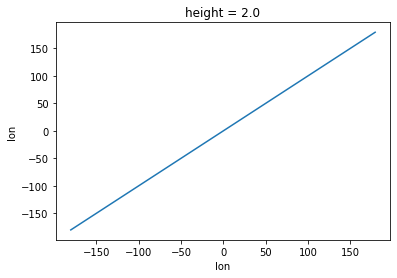

In [27]:
future.lon.plot()

In [29]:
future

<xarray.Dataset>
Dimensions:    (lat: 258, bnds: 2, lon: 512, member_id: 58, time: 1032)
Coordinates:
  * lat        (lat) float64 -89.46 -88.77 -88.07 -87.37 ... 88.07 88.77 89.46
    height     float64 ...
    lat_bnds   (lat, bnds) float64 dask.array<chunksize=(258, 2), meta=np.ndarray>
  * lon        (lon) float64 -180.0 -179.3 -178.6 -177.9 ... 177.9 178.6 179.3
    lon_bnds   (lon, bnds) float64 dask.array<chunksize=(512, 2), meta=np.ndarray>
  * time       (time) datetime64[ns] 2015-01-16T12:00:00 ... 2100-12-16T12:00:00
    time_bnds  (time, bnds) datetime64[ns] dask.array<chunksize=(1032, 2), meta=np.ndarray>
  * member_id  (member_id) <U10 'r6i1p1f1' 'r9i1p1f1' ... 'r4i1p1f1' 'r3i1p1f1'
Dimensions without coordinates: bnds
Data variables:
    tas        (member_id, time, lat, lon) float32 dask.array<chunksize=(1, 126, 258, 512), meta=np.ndarray>
Attributes: (12/49)
    activity_id:                        ScenarioMIP
    parent_source_id:                   EC-Earth3
    tracking_id:                        hdl:21.14100/ed4c0bb2-5c5d-4ea8-b28f-...
    realm:                              atmos
    parent_activity_id:                 CMIP
    grid_label:                         gr
    ...                                 ...
    license:                            CMIP6 model data produced by EC-Earth...
    history:                            2019-07-10T07:04:42Z ; CMOR rewrote d...
    source_type:                        AOGCM
    cmor_version:                       3.4.0
    physics_index:                      1
    intake_esm_dataset_key:             ScenarioMIP.EC-Earth-Consortium.EC-Ea...

In [19]:
hist = hist.sel(lat=40,lon=70,method='nearest')

In [ ]:
#         self.future.to_zarr(
#             self.future_path,
#             consolidated=True,
#             safe_chunks=False
#         )
    
#     f'gcs://{self.bucket}/{self.path}/{self.ds_name_hist}.zarr'
#     'EC-Earth3_Amon_hist_tas_40_-90'
#     bucket='climateai_data_repository', path='tmp/internal_variability'
    
    

In [24]:
hist

<xarray.Dataset>
Dimensions:    (time: 1981, bnds: 2, member_id: 73)
Coordinates:
    lat        float64 40.35
  * time       (time) datetime64[ns] 1849-12-16T12:00:00 ... 2014-12-16T12:00:00
    height     float64 ...
    lat_bnds   (bnds) float64 dask.array<chunksize=(2,), meta=np.ndarray>
    lon        float64 70.31
    lon_bnds   (bnds) float64 dask.array<chunksize=(2,), meta=np.ndarray>
    time_bnds  (time, bnds) datetime64[ns] dask.array<chunksize=(1981, 2), meta=np.ndarray>
  * member_id  (member_id) <U10 'r9i1p1f1' 'r11i1p1f1' ... 'r25i1p1f1'
Dimensions without coordinates: bnds
Data variables:
    tas        (member_id, time) float32 dask.array<chunksize=(1, 126), meta=np.ndarray>
Attributes: (12/55)
    sub_experiment:            none
    source_id:                 EC-Earth3
    institution_id:            EC-Earth-Consortium
    frequency:                 mon
    netcdf_tracking_ids:       hdl:21.14100/039476c1-576c-49d5-b15a-84bef8e5e...
    variant_label:             r25i1p1f1
    ...                        ...
    grid_label:                gr
    product:                   model-output
    tracking_id:               hdl:21.14100/1959ae44-b6dd-4975-aae3-36f6e6157...
    table_id:                  Amon
    initialization_index:      1
    intake_esm_dataset_key:    CMIP.EC-Earth-Consortium.EC-Earth3.historical....

### chunking things and trying to save


In [25]:
chunks = {'time': -1, 'member_id': -1}

In [ ]:
        # ds.chunk(chunks).to_zarr(
        #     path,
        #     consolidated=True,
        #     mode='w' if self.overwrite else 'w-'
        # )

In [27]:
hist.chunk(chunks)

<xarray.Dataset>
Dimensions:    (time: 1981, bnds: 2, member_id: 73)
Coordinates:
    lat        float64 40.35
  * time       (time) datetime64[ns] 1849-12-16T12:00:00 ... 2014-12-16T12:00:00
    height     float64 ...
    lat_bnds   (bnds) float64 dask.array<chunksize=(2,), meta=np.ndarray>
    lon        float64 70.31
    lon_bnds   (bnds) float64 dask.array<chunksize=(2,), meta=np.ndarray>
    time_bnds  (time, bnds) datetime64[ns] dask.array<chunksize=(1981, 2), meta=np.ndarray>
  * member_id  (member_id) <U10 'r9i1p1f1' 'r11i1p1f1' ... 'r25i1p1f1'
Dimensions without coordinates: bnds
Data variables:
    tas        (member_id, time) float32 dask.array<chunksize=(73, 1981), meta=np.ndarray>
Attributes: (12/55)
    sub_experiment:            none
    source_id:                 EC-Earth3
    institution_id:            EC-Earth-Consortium
    frequency:                 mon
    netcdf_tracking_ids:       hdl:21.14100/039476c1-576c-49d5-b15a-84bef8e5e...
    variant_label:             r25i1p1f1
    ...                        ...
    grid_label:                gr
    product:                   model-output
    tracking_id:               hdl:21.14100/1959ae44-b6dd-4975-aae3-36f6e6157...
    table_id:                  Amon
    initialization_index:      1
    intake_esm_dataset_key:    CMIP.EC-Earth-Consortium.EC-Earth3.historical....

In [28]:
hist.chunk(chunks).to_zarr(store=f'gcs://climateai_data_repository/tmp/test.zarr',
             consolidated=True)

ContainsGroupError: path '' contains a group

### Stephan stuff

In [3]:
cat = raw_cat.search(
    experiment_id='ssp585',
    variable_id='tas',
    table_id='Amon'
)

In [11]:
cat.df.nunique()

activity_id         1
institution_id     31
source_id          47
experiment_id       1
member_id         146
table_id            1
variable_id         1
grid_label          3
zstore            326
dcpp_init_year      0
version            71
dtype: int64

In [24]:
cat.df.groupby('source_id').member_id.count()

source_id
ACCESS-CM2           5
ACCESS-ESM1-5       35
AWI-CM-1-1-MR        1
BCC-CSM2-MR          1
CAMS-CSM1-0          2
CAS-ESM2-0           2
CESM2                3
CESM2-WACCM          5
CIESM                1
CMCC-CM2-SR5         1
CMCC-ESM2            1
CNRM-CM6-1           6
CNRM-CM6-1-HR        1
CNRM-ESM2-1          5
CanESM5             50
CanESM5-CanOE        3
E3SM-1-1             1
EC-Earth3           58
EC-Earth3-CC         1
EC-Earth3-Veg        8
EC-Earth3-Veg-LR     3
FGOALS-f3-L          1
FGOALS-g3            4
FIO-ESM-2-0          3
GFDL-CM4             1
GFDL-ESM4            1
GISS-E2-1-G         10
GISS-E2-1-H          4
HadGEM3-GC31-LL      4
HadGEM3-GC31-MM      4
IITM-ESM             1
INM-CM4-8            1
INM-CM5-0            1
IPSL-CM6A-LR         6
KACE-1-0-G           3
KIOST-ESM            1
MCM-UA-1-0           1
MIROC-ES2L           9
MIROC6              50
MPI-ESM1-2-HR        2
MPI-ESM1-2-LR       10
MRI-ESM2-0           6
NESM3                2
N

6 models with 10+ emsemble members for monthly. This is great, especially if we can also add CESM-LENS. Not quite the ensemble sizes from MMLEA, so there might be a worry that for extremes the sample is too low but that remains to be seen. 

Let's now check whether this is the same for daily data.

In [32]:
cat = raw_cat.search(
    experiment_id='ssp585',
    variable_id='tasmax',
    table_id='day'
)

In [33]:
cat.df.nunique()

activity_id         1
institution_id     24
source_id          34
experiment_id       1
member_id         128
table_id            1
variable_id         1
grid_label          4
zstore            241
dcpp_init_year      0
version            48
dtype: int64

In [34]:
cat.df.groupby('source_id').member_id.count()

source_id
ACCESS-CM2           3
ACCESS-ESM1-5       10
AWI-CM-1-1-MR        1
BCC-CSM2-MR          1
CAMS-CSM1-0          1
CESM2                3
CESM2-WACCM          4
CMCC-ESM2            1
CNRM-CM6-1           1
CNRM-CM6-1-HR        1
CNRM-ESM2-1          1
CanESM5             50
EC-Earth3           58
EC-Earth3-CC         1
EC-Earth3-Veg        8
EC-Earth3-Veg-LR     3
FGOALS-g3            4
GFDL-CM4             2
GFDL-ESM4            1
INM-CM4-8            1
INM-CM5-0            1
IPSL-CM6A-LR         6
KACE-1-0-G           3
KIOST-ESM            1
MIROC-ES2L           1
MIROC6              50
MPI-ESM1-2-HR        2
MPI-ESM1-2-LR       10
MRI-ESM2-0           6
NESM3                2
NorESM2-LM           1
NorESM2-MM           1
TaiESM1              1
UKESM1-0-LL          1
Name: member_id, dtype: int64

Now we only have 5, GISS is missing in daily but that's ok, it only had 10 members anyway. pr, tas, tasmax and tasmin are all the same. This is good news. Hurray for cloud data! 